In [ ]:
# Loading packages
from google.colab import drive
import os
from torchvision import transforms 
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
import torch.optim as optim
import random
from tqdm.notebook import tqdm
import numpy as np

# Also, as we have a auxiliar python file with function, we go to use it
from cnn_functions import *

In [ ]:
# As our dataset is mounted in Google Drive, we need to get access to it.
drive.mount('/content/drive')

# Dataset path. You should change the dataset path to the location that you place the data.
data_dir = '/content/drive/MyDrive/DeepLearning/dataset/'
classes = os.listdir(data_dir)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Performing Image Transformations. 
train_transform = transforms.Compose([
            transforms.Resize(256),
            transforms.RandomHorizontalFlip(),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

In [ ]:
# Checking the dataset training size
dataset = ImageFolder(data_dir, transform=train_transform)
print('Size of training dataset :', len(dataset))

Size of training dataset : 5400


In [ ]:
# Viewing one of images shape
img, label = dataset[100]
print(img.shape)

torch.Size([3, 224, 224])


In [ ]:
# Setting seed so that value won't change everytime
# Splitting the dataset to training, validation, and testing category
torch.manual_seed(1)
val_size = len(dataset)//20
test_size = len(dataset)//10
train_size = len(dataset) - val_size - test_size

In [ ]:
# Random Splitting
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])
# Check the size of each dataset
len(train_ds), len(val_ds),len(test_ds)  

(4590, 270, 540)

In [ ]:
# Define batch size
batch_size = 12
# Define a generator of random values
g_cpu = torch.Generator()
g_cpu.manual_seed(123)
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True,generator  = g_cpu)
val_loader = DataLoader(val_ds, batch_size, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size, num_workers=2, pin_memory=True)

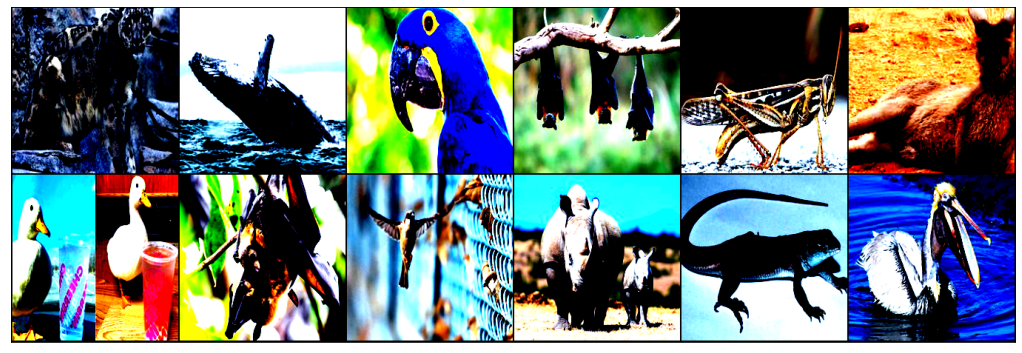

In [ ]:
# We can see some of these images available in one batch
for images, labels in train_loader:
    fig, ax = plt.subplots(figsize=(18,10))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=6).permute(1, 2, 0))
    break

In [ ]:
# Now, we go to consider some parameters to start to create our models
input_size = torch.randn(1, 3, 224, 224)
output_size = 90

# Pass our data to GPU
device = get_default_device()
device
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

# **Create Resnet34 Model**

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, inchannel, outchannel, stride=1, shortcut=None):
        super(ResidualBlock, self).__init__()
        self.left = nn.Sequential(
                nn.Conv2d(inchannel, outchannel, 3, stride, 1, bias=False),
                nn.BatchNorm2d(outchannel),
                nn.ReLU(inplace=True),
                nn.Conv2d(outchannel, outchannel, 3, 1, 1, bias=False),
                nn.BatchNorm2d(outchannel) )
        self.right = shortcut

    def forward(self, x):
        out = self.left(x)
        residual = x if self.right is None else self.right(x)
        out += residual
        return F.relu(out)

class ResNet34(nn.Module):
    def __init__(self, num_classes):
        super(ResNet34, self).__init__()
        self.pre = nn.Sequential(
                nn.Conv2d(3, 64, 7, 2, 3, bias=False),
                nn.BatchNorm2d(64),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(3, 2, 1))
        self.layer1 = self._make_layer( 64, 128, 3)
        self.layer2 = self._make_layer( 128, 256, 4, stride=2)
        self.layer3 = self._make_layer( 256, 512, 6, stride=2)
        self.layer4 = self._make_layer( 512, 512, 3, stride=2)
        self.fc = nn.Linear(512, num_classes)
    
    def _make_layer(self,  inchannel, outchannel, block_num, stride=1):
        shortcut = nn.Sequential(
                nn.Conv2d(inchannel,outchannel,1,stride, bias=False),
                nn.BatchNorm2d(outchannel))
        
        layers = []
        layers.append(ResidualBlock(inchannel, outchannel, stride, shortcut))
        
        for i in range(1, block_num):
            layers.append(ResidualBlock(outchannel, outchannel))
        return nn.Sequential(*layers)
        
    def forward(self, x):
        x = self.pre(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = F.avg_pool2d(x, 7)
        x = x.view(x.size(0), -1)
        return self.fc(x)

In [ ]:
# Reporting the Flops of this model
print_model_parm_flops(ResNet34(90),input_size, detail=False)

 + Number of FLOPs: 24.41G


# **Resnet34, Loss function: Cross entropy, Optimizer: SGD, learning rate:0.01, epochs:20**

In [ ]:
cnn_sgd_lr001_performance = fit_model(ResNet34(90),train_loader = train_loader,val_loader = val_loader,test_loader =test_loader,optimization = 'SGD',loss_function = 'Cross-entropy',epochs = 20,learning_rate = 0.01)

  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.608


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.321


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.171


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.052


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:3.904


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:3.763


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:3.599


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:3.454


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:3.296


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:3.143


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:2.986


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:2.875


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:2.715


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:2.572


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:2.465


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:2.327


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:2.195


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:2.041


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:1.882


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:1.723
Finished Training


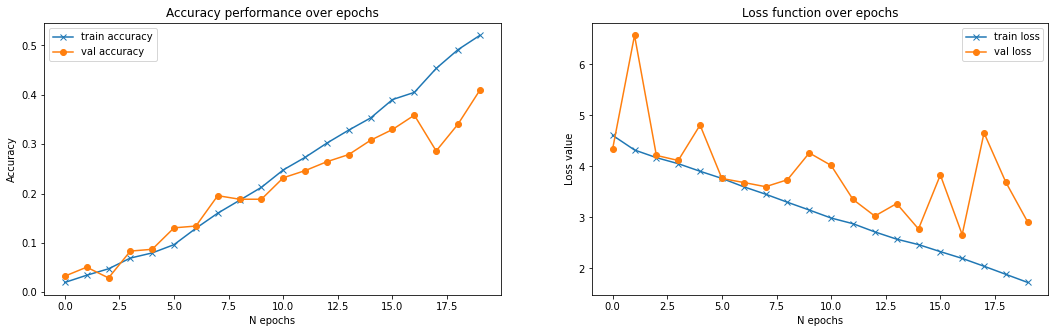

In [ ]:
# Plot results
plot_performance(cnn_sgd_lr001_performance[1],cnn_sgd_lr001_performance[2])

In [ ]:
# Reporting test accuracy
print(f'Accuracy in testing is: {cnn_sgd_lr001_performance[3][0].cpu()}')

Accuracy in testing is: 0.37037035822868347


# **ResNet34, Loss function: Cross entropy, Optimizer: SGD, learning rate:0.001, epochs:20**

In [ ]:
cnn_sdg_lr01_performance = fit_model(ResNet34(90),train_loader = train_loader,val_loader = val_loader,test_loader =test_loader,optimization = 'SGD',loss_function = 'Cross-entropy',epochs = 20,learning_rate = 0.001)

  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.348


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:3.910


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:3.589


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:3.345


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:3.101


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:2.900


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:2.709


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:2.531


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:2.320


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:2.118


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:1.887


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:1.679


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:1.457


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:1.253


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:1.034


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:0.791


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:0.660


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:0.477


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:0.355


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:0.281
Finished Training


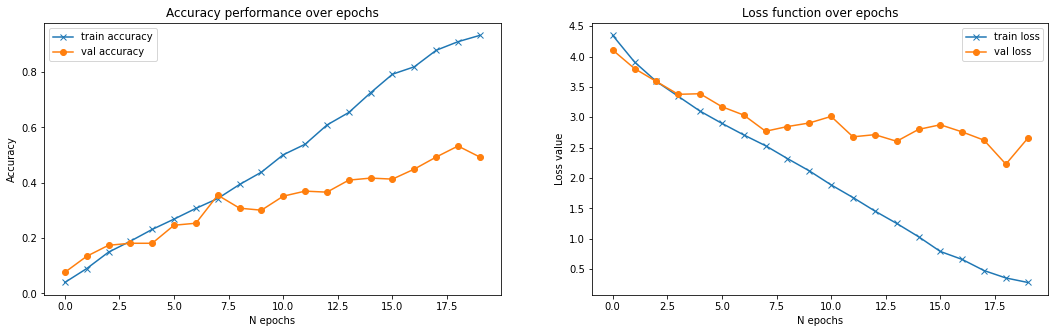

In [ ]:
# Plot results
plot_performance(cnn_sdg_lr01_performance[1],cnn_sdg_lr01_performance[2])

In [ ]:
# Reporting test accuracy
print(f'Accuracy in testing is: {cnn_sdg_lr01_performance[3][0].cpu()}')

Accuracy in testing is: 0.5203704237937927


# **ResNet34, Loss function: Cross entropy, Optimizer: Adam, learning rate:0.01, epochs:20**

In [ ]:
cnn_adam_lr001_performance = fit_model(ResNet34(90),train_loader = train_loader,val_loader = val_loader,test_loader =test_loader,optimization = 'Adam',loss_function = 'Cross-entropy',epochs = 20,learning_rate = 0.01)

  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.637


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.453


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.427


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.392


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.355


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.281


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.216


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.155


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.086


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:3.990


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:3.867


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:3.780


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:3.674


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:3.547


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:3.420


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:3.258


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:3.103


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:2.921


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:2.766


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:2.575
Finished Training


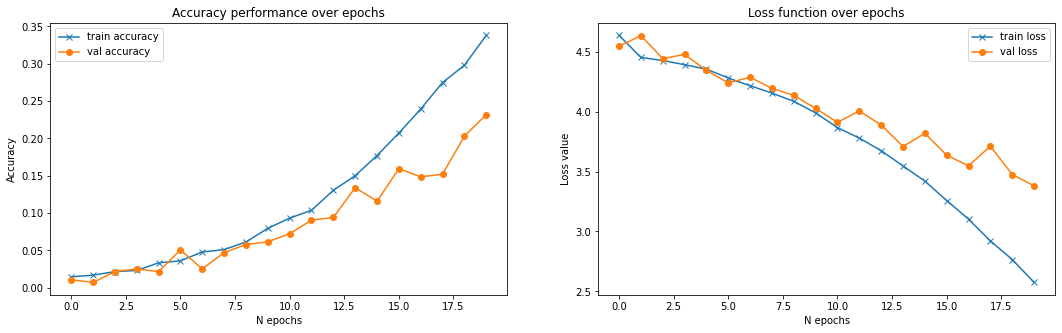

In [ ]:
# Plot results
plot_performance(cnn_adam_lr001_performance[1],cnn_adam_lr001_performance[2])

In [ ]:
# Reporting test accuracy
print(f'Accuracy in testing is: {cnn_adam_lr001_performance[3][0].cpu()}')

Accuracy in testing is: 0.24629633128643036


# **ResNet34, Loss function: Cross entropy, Optimizer: Adam, learning rate:0.001, epochs:20**

In [ ]:
cnn_adam_lr01_performance = fit_model(ResNet34(90),train_loader = train_loader,val_loader = val_loader,test_loader =test_loader,optimization = 'Adam',loss_function = 'Cross-entropy',epochs = 20,learning_rate = 0.001)

  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.585


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.416


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.332


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.265


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.135


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.044


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:3.939


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:3.793


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:3.656


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:3.527


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:3.433


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:3.295


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:3.140


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:2.983


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:2.871


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:2.695


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:2.534


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:2.363


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:2.184


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:2.040
Finished Training


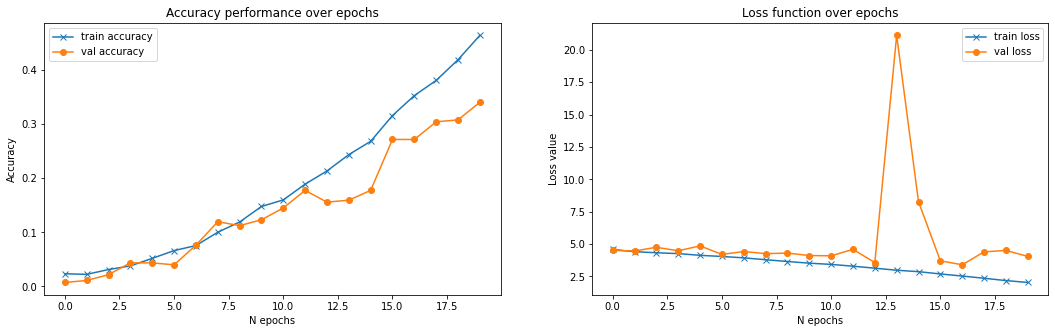

In [ ]:
# Plot results
plot_performance(cnn_adam_lr01_performance[1],cnn_adam_lr01_performance[2])

In [ ]:
# Reporting test accuracy
print(f'Accuracy in testing is: {cnn_adam_lr01_performance[3][0].cpu()}')

Accuracy in testing is: 0.3611111342906952


# **ResNet34 pretrained Model**

In [ ]:
model_resnet34_pt = torch.hub.load('pytorch/vision:v0.10.0', 'resnet34', pretrained=True)
model_resnet34_pt.fc = nn.Linear(512,90)
model_resnet34_pt.eval()

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# **Resnet34 pretrained, Loss function: Cross entropy, Optimizer: SGD, learning rate:0.01, epochs:20**

In [ ]:
cnn_sgd_lr001_performance = fit_model(model_resnet34_pt,train_loader = train_loader,val_loader = val_loader,test_loader =test_loader,optimization = 'SGD',loss_function = 'Cross-entropy',epochs = 20,learning_rate = 0.01)

  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:3.400


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:1.996


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:1.468


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:1.035


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:0.758


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:0.588


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:0.372


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:0.292


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:0.253


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:0.173


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:0.111


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:0.110


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:0.065


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:0.060


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:0.027


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:0.027


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:0.033


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:0.028


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:0.017


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:0.021
Finished Training


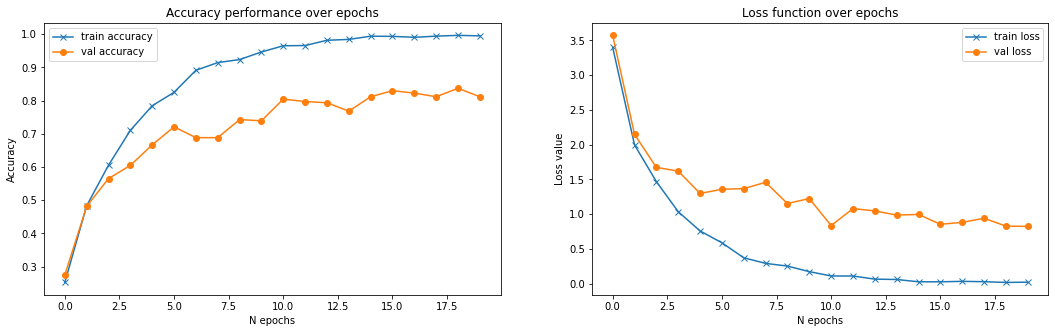

In [ ]:
# Plot results
plot_performance(cnn_sgd_lr001_performance[1],cnn_sgd_lr001_performance[2])

In [ ]:
# Reporting test accuracy
print(f'Accuracy in testing is: {cnn_sgd_lr001_performance[3][0].cpu()}')

Accuracy in testing is: 0.7962961792945862


# **ResNet34 pretrained, Loss function: Cross entropy, Optimizer: SGD, learning rate:0.001, epochs:20**

In [ ]:
model_resnet34_pt = torch.hub.load('pytorch/vision:v0.10.0', 'resnet34', pretrained=True)
model_resnet34_pt.fc = nn.Linear(512,90)
model_resnet34_pt.eval()
cnn_sdg_lr01_performance = fit_model(model_resnet34_pt,train_loader = train_loader,val_loader = val_loader,test_loader =test_loader,optimization = 'SGD',loss_function = 'Cross-entropy',epochs = 20,learning_rate = 0.001)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:2.377


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:0.681


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:0.328


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:0.189


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:0.120


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:0.085


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:0.062


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:0.049


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:0.038


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:0.034


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:0.027


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:0.025


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:0.021


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:0.017


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:0.018


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:0.016


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:0.014


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:0.014


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:0.012


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:0.012
Finished Training


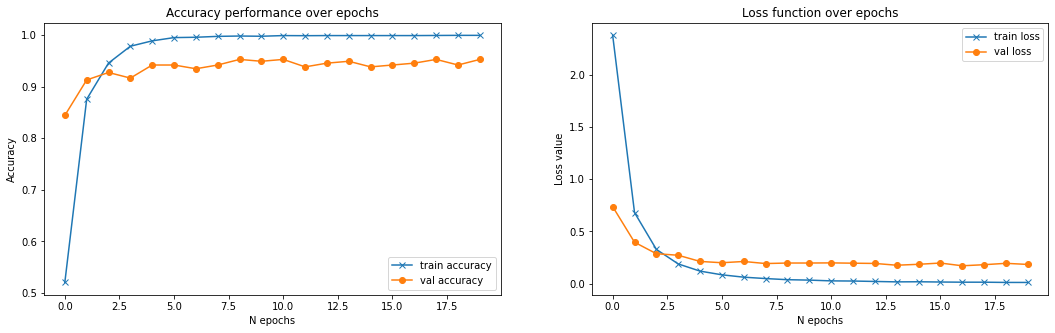

In [ ]:
# Plot results
plot_performance(cnn_sdg_lr01_performance[1],cnn_sdg_lr01_performance[2])

In [ ]:
# Reporting test accuracy
print(f'Accuracy in testing is: {cnn_sdg_lr01_performance[3][0].cpu()}')

Accuracy in testing is: 0.9370369911193848


# **ResNet34 pretrained, Loss function: Cross entropy, Optimizer: Adam, learning rate:0.01, epochs:20**

In [ ]:
model_resnet34_pt = torch.hub.load('pytorch/vision:v0.10.0', 'resnet34', pretrained=True)
model_resnet34_pt.fc = nn.Linear(512,90)
model_resnet34_pt.eval()
cnn_adam_lr001_performance = fit_model(model_resnet34_pt,train_loader = train_loader,val_loader = val_loader,test_loader =test_loader,optimization = 'Adam',loss_function = 'Cross-entropy',epochs = 20,learning_rate = 0.01)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.677


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.453


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.374


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.325


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.306


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.295


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.263


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.265


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.233


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.213


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.207


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.195


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.179


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.157


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.083


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.032


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:3.960


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:3.877


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:3.793


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:3.670
Finished Training


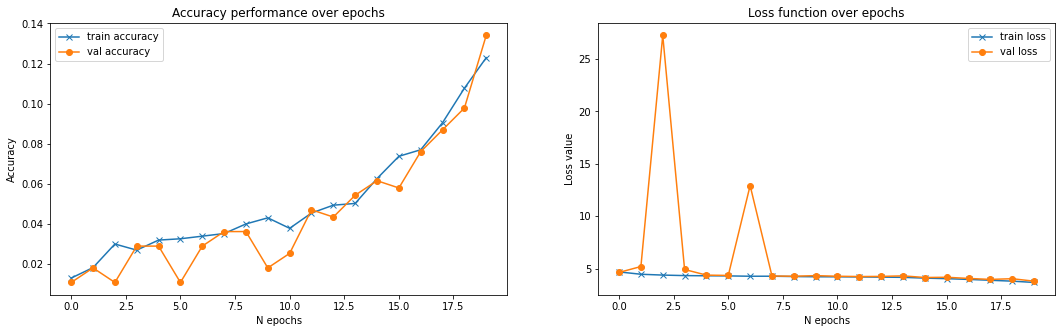

In [ ]:
# Plot results
plot_performance(cnn_adam_lr001_performance[1],cnn_adam_lr001_performance[2])

In [ ]:
# Reporting test accuracy
print(f'Accuracy in testing is: {cnn_adam_lr001_performance[3][0].cpu()}')

Accuracy in testing is: 0.15185187757015228


# **ResNet34 pretrained, Loss function: Cross entropy, Optimizer: Adam, learning rate:0.001, epochs:20**

In [ ]:
model_resnet34_pt = torch.hub.load('pytorch/vision:v0.10.0', 'resnet34', pretrained=True)
model_resnet34_pt.fc = nn.Linear(512,90)
model_resnet34_pt.eval()
cnn_adam_lr01_performance = fit_model(model_resnet34_pt,train_loader = train_loader,val_loader = val_loader,test_loader =test_loader,optimization = 'Adam',loss_function = 'Cross-entropy',epochs = 20,learning_rate = 0.001)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.461


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.039


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:3.764


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:3.541


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:3.250


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:2.965


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:2.729


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:2.487


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:2.257


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:1.968


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:1.823


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:1.526


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:1.282


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:1.028


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:0.811


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:0.675


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:0.509


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:0.436


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:0.345


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:0.304
Finished Training


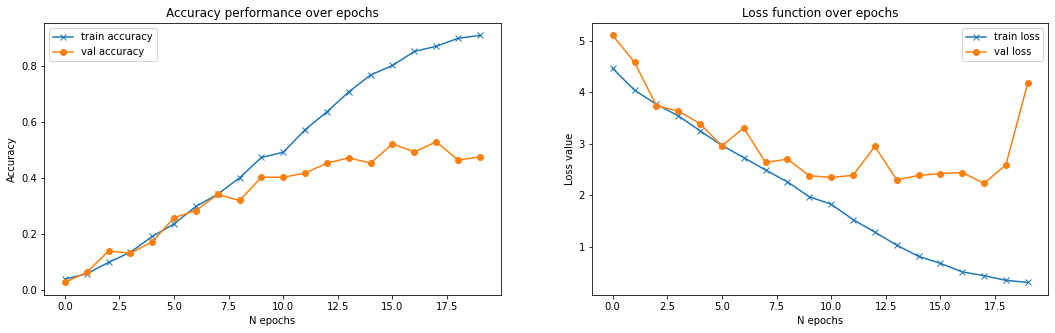

In [ ]:
# Plot results
plot_performance(cnn_adam_lr01_performance[1],cnn_adam_lr01_performance[2])

In [ ]:
# Reporting test accuracy
print(f'Accuracy in testing is: {cnn_adam_lr01_performance[3][0].cpu()}')

Accuracy in testing is: 0.49629631638526917
